In [187]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv


In [188]:
# Load the dataset with the specified encoding
retail = pd.read_csv("/kaggle/input/online-retail-customer-clustering/OnlineRetail.csv", encoding="ISO-8859-1")

# Display the first few rows of the dataset
retail.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [189]:
#dropping rows with 0 customer id
retail = retail.dropna(subset=['CustomerID'])

In [190]:
retail.describe()

Quantity      UnitPrice     CustomerID
count  406829.000000  406829.000000  406829.000000
mean       12.061303       3.460471   15287.690570
std       248.693370      69.315162    1713.600303
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   13953.000000
50%         5.000000       1.950000   15152.000000
75%        12.000000       3.750000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [191]:
#as minimum of quantity is neagative, we remove rows with <=0 quantity. 
# Display the original number of rows
print("Original number of rows:", retail.shape[0])
# Remove entries where Quantity is 0 or less
retail = retail[retail['Quantity'] > 0]
# Display the number of rows after filtering
print("Number of rows after filtering:", retail.shape[0])

# Verify that all remaining Quantity values are positive
print("All quantities are positive:", (retail['Quantity'] > 0).all())

Original number of rows: 406829
Number of rows after filtering: 397924
All quantities are positive: True


In [192]:
retail.describe()

Quantity      UnitPrice     CustomerID
count  397924.000000  397924.000000  397924.000000
mean       13.021823       3.116174   15294.315171
std       180.420210      22.096788    1713.169877
min         1.000000       0.000000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

In [193]:
retail.head(25)

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5     536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6     536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7     536366     22633               HAND WARMER UNION JACK         6   
8     536366     22632            HAND WARMER RED POLKA DOT         6   
9     536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   
10    536367     22745           POPPY'S PLAYHOUSE BEDROOM          6   
11    536367     22748            POPPY'S PLAYHOUSE KITCHEN         6   
12    536367     22749    FELTCRAFT PRINCESS CHARLOTTE DOLL         8   
13    536367     22310              IVORY KNITTED MUG COSY          6   
14    536367     84969   BOX OF 6 ASSORTED COLOUR TEASPOONS         6   
15    536367     22623        BOX OF VINTAGE JIGSAW BLOCKS          3   
16    536367     22622       BOX OF VINTAGE ALPHABET BLOCKS         2   
17    536367     21754             HOME BUILDING BLOCK WORD         3   
18    536367     21755             LOVE BUILDING BLOCK WORD         3   
19    536367     21777          RECIPE BOX WITH METAL HEART         4   
20    536367     48187                  DOORMAT NEW ENGLAND         4   
21    536368     22960             JAM MAKING SET WITH JARS         6   
22    536368     22913          RED COAT RACK PARIS FASHION         3   
23    536368     22912       YELLOW COAT RACK PARIS FASHION         3   
24    536368     22914         BLUE COAT RACK PARIS FASHION         3   

         InvoiceDate  UnitPrice  CustomerID         Country  
0   01-12-2010 08:26       2.55     17850.0  United Kingdom  
1   01-12-2010 08:26       3.39     17850.0  United Kingdom  
2   01-12-2010 08:26       2.75     17850.0  United Kingdom  
3   01-12-2010 08:26       3.39     17850.0  United Kingdom  
4   01-12-2010 08:26       3.39     17850.0  United Kingdom  
5   01-12-2010 08:26       7.65     17850.0  United Kingdom  
6   01-12-2010 08:26       4.25     17850.0  United Kingdom  
7   01-12-2010 08:28       1.85     17850.0  United Kingdom  
8   01-12-2010 08:28       1.85     17850.0  United Kingdom  
9   01-12-2010 08:34       1.69     13047.0  United Kingdom  
10  01-12-2010 08:34       2.10     13047.0  United Kingdom  
11  01-12-2010 08:34       2.10     13047.0  United Kingdom  
12  01-12-2010 08:34       3.75     13047.0  United Kingdom  
13  01-12-2010 08:34       1.65     13047.0  United Kingdom  
14  01-12-2010 08:34       4.25     13047.0  United Kingdom  
15  01-12-2010 08:34       4.95     13047.0  United Kingdom  
16  01-12-2010 08:34       9.95     13047.0  United Kingdom  
17  01-12-2010 08:34       5.95     13047.0  United Kingdom  
18  01-12-2010 08:34       5.95     13047.0  United Kingdom  
19  01-12-2010 08:34       7.95     13047.0  United Kingdom  
20  01-12-2010 08:34       7.95     13047.0  United Kingdom  
21  01-12-2010 08:34       4.25     13047.0  United Kingdom  
22  01-12-2010 08:34       4.95     13047.0  United Kingdom  
23  01-12-2010 08:34       4.95     13047.0  United Kingdom  
24  01-12-2010 08:34       4.95     13047.0  United Kingdom

We see that several invoices per each customer. each invoice itslef has many items in the order, so we will multiply each quantity with unit price.

In [194]:

# Creating a new column by multiplying 'Quantity' and 'UnitPrice'
retail['Paid'] = retail['Quantity'] * retail['UnitPrice']

# Displaying the updated DataFrame
retail.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country   Paid  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34

In [195]:
#we see same invoice has many items, so we will add the paid amount of each invoice
rfm_details = retail.groupby(['CustomerID','InvoiceNo']).agg({'Paid': 'sum'}).reset_index()
rfm_details.head()

CustomerID InvoiceNo      Paid
0     12346.0    541431  77183.60
1     12347.0    537626    711.79
2     12347.0    542237    475.39
3     12347.0    549222    636.25
4     12347.0    556201    382.52

In [196]:
#how much each customer paid (sum of all invoices)
rfm_details2 = rfm_details.groupby(['CustomerID']).agg({'Paid':'sum'}).reset_index()
rfm_details2.head()

CustomerID      Paid
0     12346.0  77183.60
1     12347.0   4310.00
2     12348.0   1797.24
3     12349.0   1757.55
4     12350.0    334.40

In [197]:
#how many times each customer ordered (no. of unique invoices or frequency)
frequency_data = retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_data.columns = ['CustomerID', 'Frequency']
rfm_details2 = pd.merge(rfm_details2, frequency_data, on='CustomerID', how='left')
rfm_details2.head()

CustomerID      Paid  Frequency
0     12346.0  77183.60          1
1     12347.0   4310.00          7
2     12348.0   1797.24          4
3     12349.0   1757.55          1
4     12350.0    334.40          1

In [198]:
#making a copy of df
rfm_details3 = rfm_details2.copy()
rfm_details3.head()

CustomerID      Paid  Frequency
0     12346.0  77183.60          1
1     12347.0   4310.00          7
2     12348.0   1797.24          4
3     12349.0   1757.55          1
4     12350.0    334.40          1

In [199]:
#lets find most recent transaction and then find difference of number of days from that to the last transaction for each customer for **recency**
last_date = max(retail['InvoiceDate'])
print(last_date)

31-10-2011 17:13


In [200]:
retail_copy = retail.copy()
retail_copy.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country   Paid  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  15.30  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  22.00  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  20.34

In [201]:
#converting datetime to standard format
retail_copy['InvoiceDate'] = pd.to_datetime(retail_copy['InvoiceDate'], format='%d-%m-%Y %H:%M')
retail_copy.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country   Paid  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34

In [202]:
max_date = retail_copy['InvoiceDate'].max()

# Calculate the difference between the maximum date and each 'InvoiceDate'
retail_copy['diff'] = max_date - retail_copy['InvoiceDate']

retail_copy.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country   Paid  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   

               diff  
0 373 days 04:24:00  
1 373 days 04:24:00  
2 373 days 04:24:00  
3 373 days 04:24:00  
4 373 days 04:24:00

In [203]:
retail_copy['diff_days'] = retail_copy['diff'].dt.days

# Find the minimum 'diff_days' for each 'CustomerID'
min_diff_per_customer = retail_copy.groupby('CustomerID')['diff_days'].min().reset_index()
min_diff_per_customer.columns = ['CustomerID', 'time']
retail_copy['diff_days'] = retail_copy['diff'].dt.days

# Find the minimum 'diff_days' for each 'CustomerID'
min_diff_per_customer = retail_copy.groupby('CustomerID')['diff_days'].min().reset_index()
min_diff_per_customer.columns = ['CustomerID', 'time']

retail_copy.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country   Paid  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  20.34   

               diff  diff_days  
0 373 days 04:24:00        373  
1 373 days 04:24:00        373  
2 373 days 04:24:00        373  
3 373 days 04:24:00        373  
4 373 days 04:24:00        373

In [204]:
rfm_details3 = pd.merge(rfm_details3, min_diff_per_customer, on='CustomerID', how='left')
rfm_details3.head()

CustomerID      Paid  Frequency  time
0     12346.0  77183.60          1   325
1     12347.0   4310.00          7     1
2     12348.0   1797.24          4    74
3     12349.0   1757.55          1    18
4     12350.0    334.40          1   309

In [205]:
columns_to_scale = ['Paid', 'Frequency', 'time']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the specified columns
rfm_details3[columns_to_scale] = scaler.fit_transform(rfm_details3[columns_to_scale])

# Create the new DataFrame rfm_details4 with the scaled values and include the 'CustomerID' column
rfm_details4 = rfm_details3.copy()

rfm_details4.head()

CustomerID      Paid  Frequency      time
0     12346.0  0.275453   0.000000  0.871314
1     12347.0  0.015382   0.028708  0.002681
2     12348.0  0.006414   0.014354  0.198391
3     12349.0  0.006272   0.000000  0.048257
4     12350.0  0.001193   0.000000  0.828418

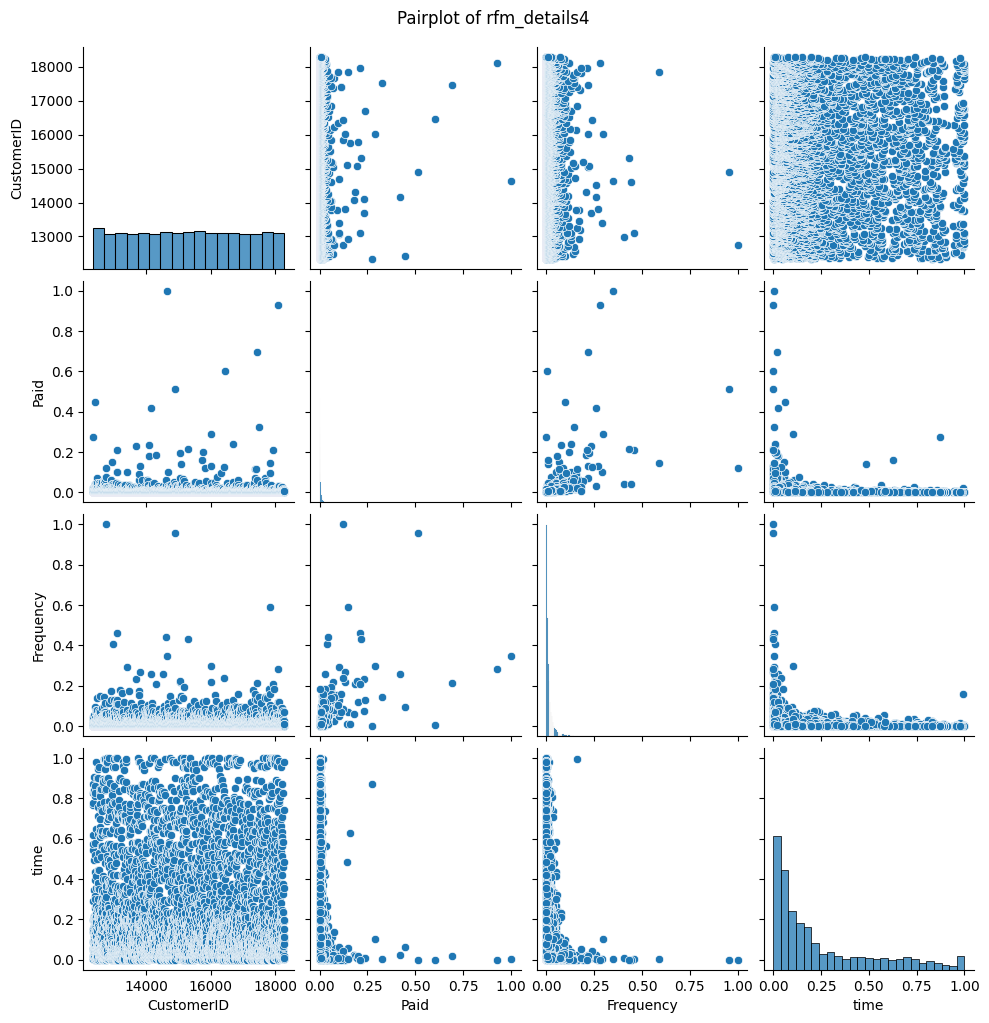

In [206]:

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Create the pairplot
    sns.pairplot(rfm_details4)
    plt.suptitle('Pairplot of rfm_details4', y=1.02)
    plt.show()


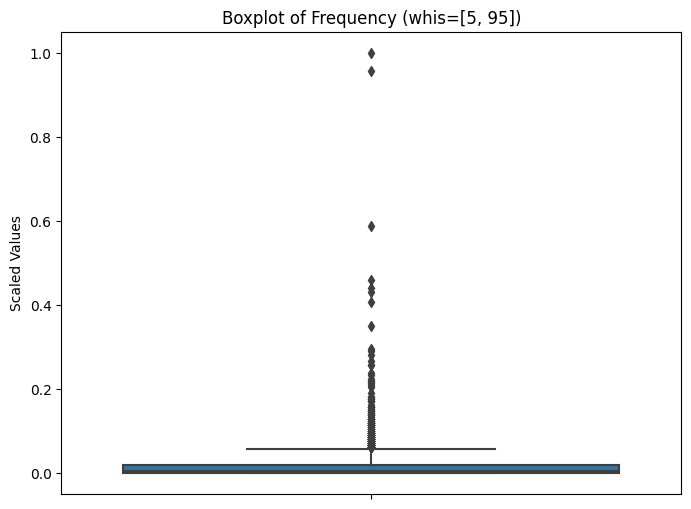

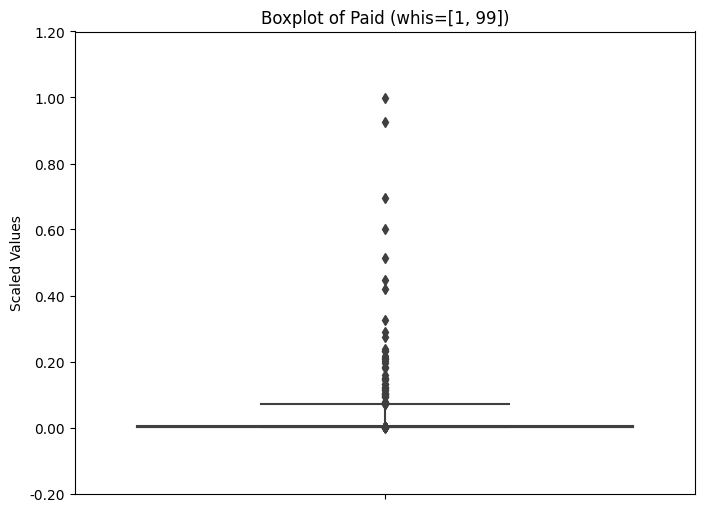

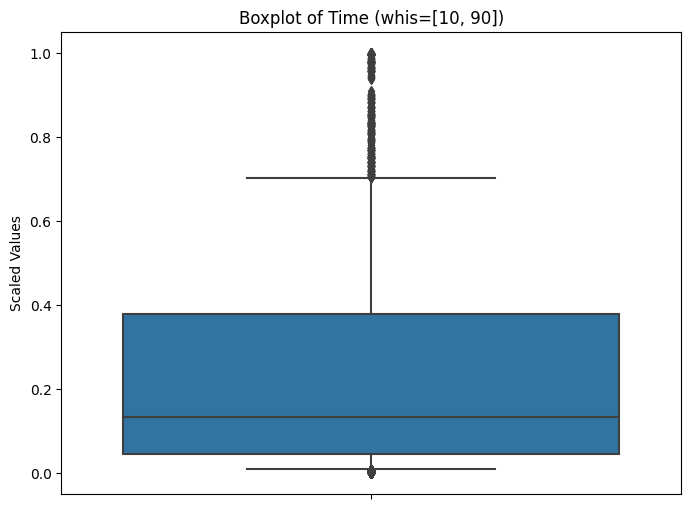

In [207]:

# Create boxplot for 'Frequency'
plt.figure(figsize=(8, 6))
sns.boxplot(y=rfm_details4['Frequency'], whis=[5, 95])
plt.title('Boxplot of Frequency (whis=[5, 95])')
plt.ylabel('Scaled Values')
plt.show()

# Create boxplot for 'Paid' with smaller scale
plt.figure(figsize=(8, 6))
sns.boxplot(y=rfm_details4['Paid'], whis=[1, 99])
plt.title('Boxplot of Paid (whis=[1, 99])')
plt.ylabel('Scaled Values')
plt.yticks(ticks=plt.yticks()[0], labels=[f"{tick:.2f}" for tick in plt.yticks()[0]])  # Change y-axis ticks to display with 2 decimal places
plt.show()

# Create boxplot for 'time' with different scale
plt.figure(figsize=(8, 6))
sns.boxplot(y=rfm_details4['time'], whis=[10, 90])
plt.title('Boxplot of Time (whis=[10, 90])')
plt.ylabel('Scaled Values')
plt.show()


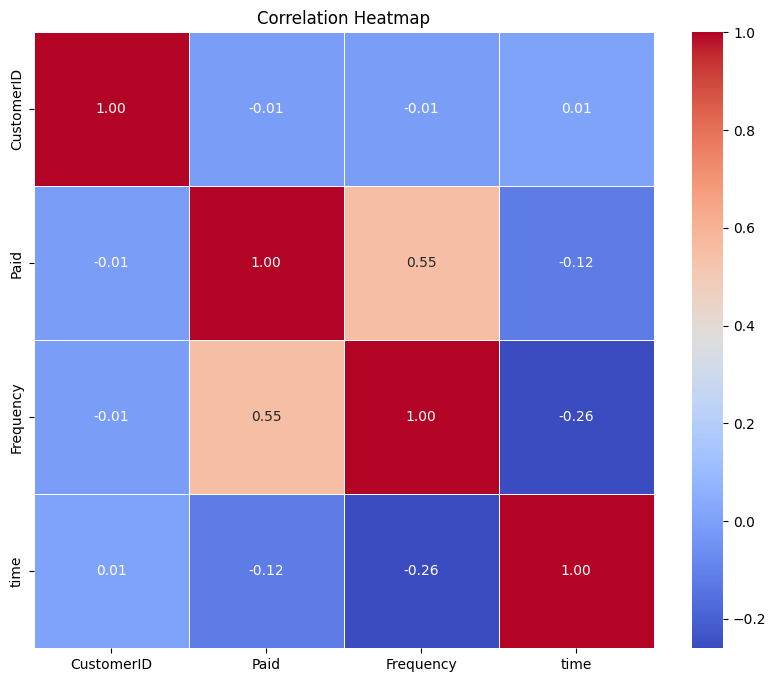

In [208]:
correlation_matrix = rfm_details4.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

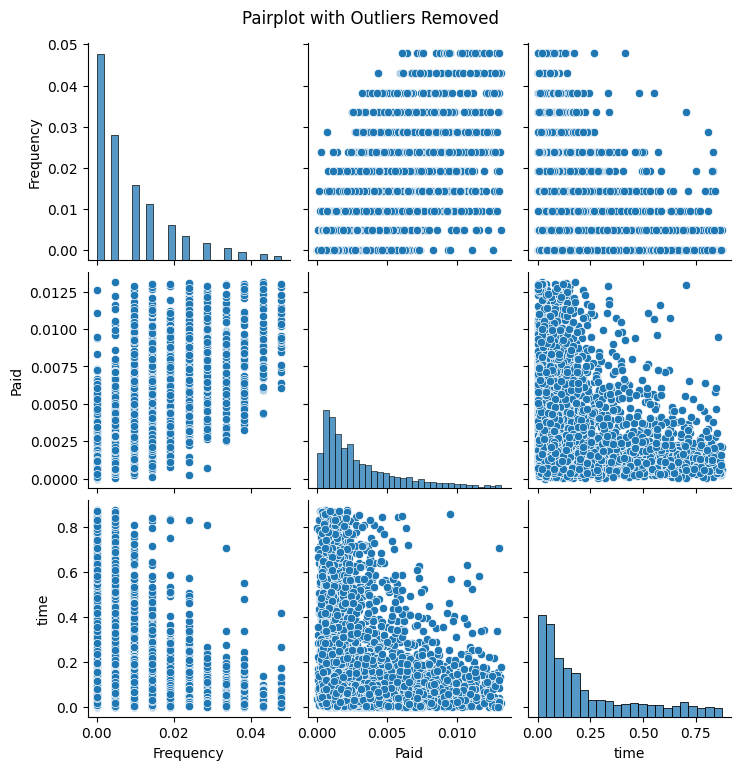

In [209]:
# Assuming rfm_details4 DataFrame is already defined
# For demonstration, let's assume the DataFrame is already loaded and has the required columns

# Define columns for outlier detection (excluding 'CustomerID')
scatter_columns = ['Frequency', 'Paid', 'time']

# Calculate quartiles and IQR for specified columns in rfm_details4
Q1 = rfm_details4[scatter_columns].quantile(0.25)
Q3 = rfm_details4[scatter_columns].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Filter the data to remove outliers, excluding 'CustomerID'
    filtered_data = rfm_details4.copy()
    for col in scatter_columns:
        filtered_data = filtered_data[(filtered_data[col] >= lower_bound[col]) & (filtered_data[col] <= upper_bound[col])]

    # Create scatter plots for each pair of columns with outliers removed
    sns.pairplot(filtered_data[scatter_columns])
    plt.suptitle('Pairplot with Outliers Removed', y=1.02)
    plt.show()


In [210]:
filtered_data.head(5)

CustomerID      Paid  Frequency      time
2     12348.0  0.006414   0.014354  0.198391
3     12349.0  0.006272   0.000000  0.048257
4     12350.0  0.001193   0.000000  0.828418
5     12352.0  0.008944   0.033493  0.093834
6     12353.0  0.000318   0.000000  0.544236

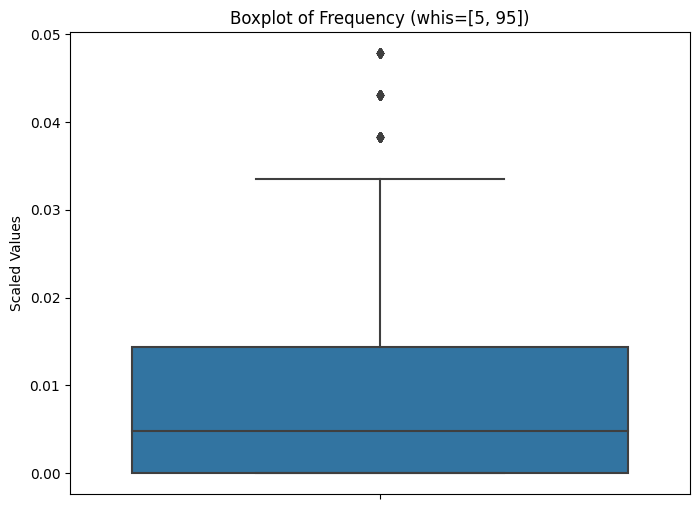

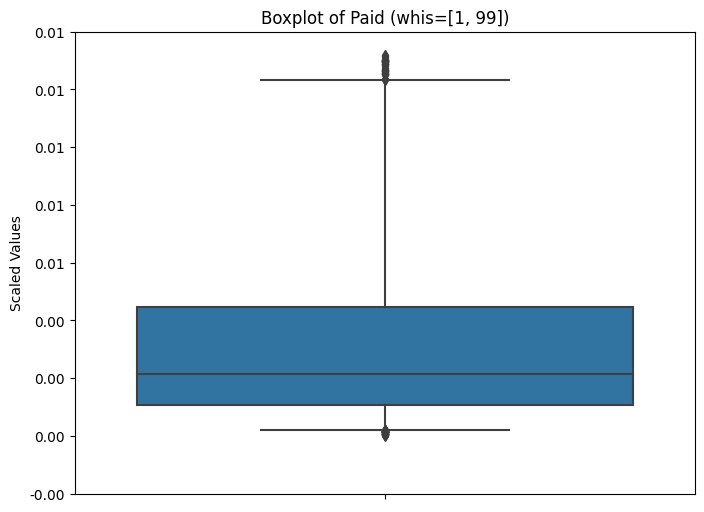

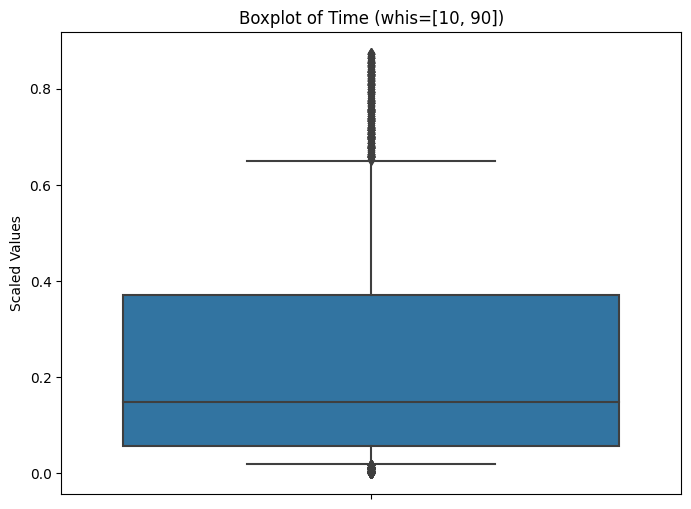

In [211]:
# Create boxplot for 'Frequency'
plt.figure(figsize=(8, 6))
sns.boxplot(y=filtered_data['Frequency'], whis=[5, 95])
plt.title('Boxplot of Frequency (whis=[5, 95])')
plt.ylabel('Scaled Values')
plt.show()

# Create boxplot for 'Paid' with smaller scale
plt.figure(figsize=(8, 6))
sns.boxplot(y=filtered_data['Paid'], whis=[1, 99])
plt.title('Boxplot of Paid (whis=[1, 99])')
plt.ylabel('Scaled Values')
plt.yticks(ticks=plt.yticks()[0], labels=[f"{tick:.2f}" for tick in plt.yticks()[0]])  # Change y-axis ticks to display with 2 decimal places
plt.show()

# Create boxplot for 'time' with different scale
plt.figure(figsize=(8, 6))
sns.boxplot(y=filtered_data['time'], whis=[10, 90])
plt.title('Boxplot of Time (whis=[10, 90])')
plt.ylabel('Scaled Values')
plt.show()

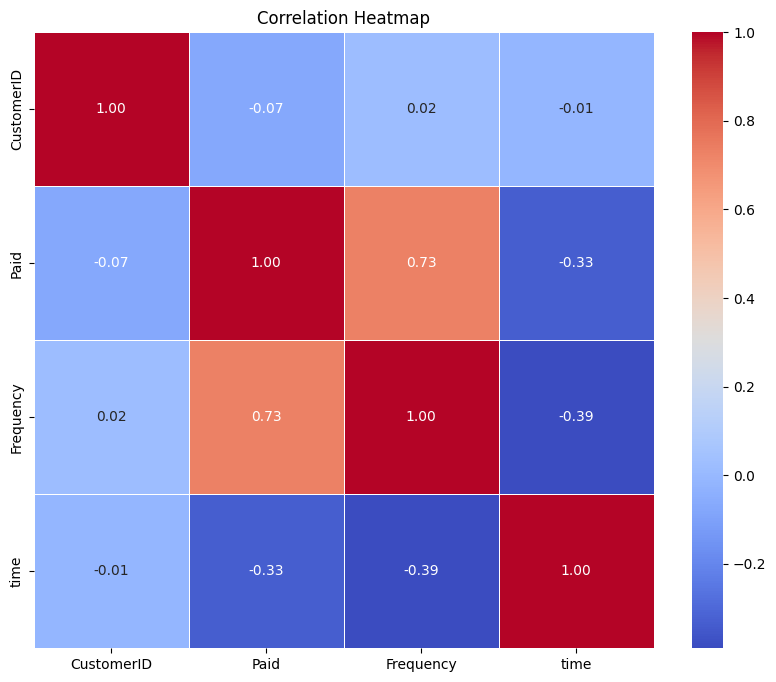

In [212]:
correlation_matrix = filtered_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [213]:
filtered_data.head()

CustomerID      Paid  Frequency      time
2     12348.0  0.006414   0.014354  0.198391
3     12349.0  0.006272   0.000000  0.048257
4     12350.0  0.001193   0.000000  0.828418
5     12352.0  0.008944   0.033493  0.093834
6     12353.0  0.000318   0.000000  0.544236

In [214]:
filtered_data2 = filtered_data.copy()

In [215]:
filtered_data_untouched = filtered_data.copy()

In [216]:
filtered_data4 = filtered_data_untouched.copy()

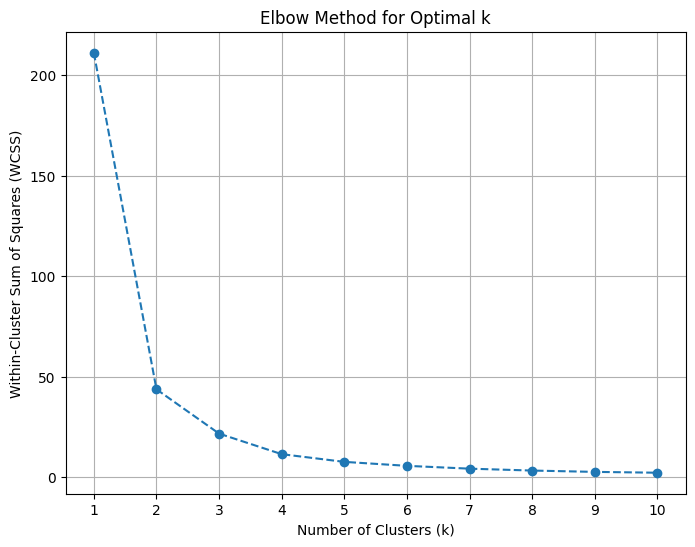

In [217]:
#we have removed outliers, so now lets proceed with clustering.

columns_for_elbow = ['Frequency', 'time', 'Paid']

# Convert DataFrame to array
X = filtered_data[columns_for_elbow].values

# Calculate within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

In [218]:
# Define columns for clustering
cluster_columns = ['Frequency', 'time', 'Paid']

# Convert DataFrame to array
X = filtered_data[cluster_columns].values

# Initialize a list to store silhouette scores
silhouette_scores = []

# Set the range of k values for silhouette analysis
k_range = range(2, 6)

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Perform silhouette analysis for each value of k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Print silhouette scores for each value of k
for k, silhouette_avg in zip(k_range, silhouette_scores):
    print(f"For n_clusters = {k}, the average silhouette score is {silhouette_avg:.4f}")


For n_clusters = 2, the average silhouette score is 0.7226
For n_clusters = 3, the average silhouette score is 0.6379
For n_clusters = 4, the average silhouette score is 0.5986
For n_clusters = 5, the average silhouette score is 0.5833


In [219]:
cluster_columns = ['Frequency', 'time', 'Paid']

# Convert DataFrame to array
X = filtered_data[cluster_columns].values

# Initialize a list to store silhouette scores
silhouette_scores = []

# Set the range of n_clusters values for silhouette analysis
n_clusters_range = range(2, 6)

# Perform silhouette analysis for each value of n_clusters
for n_clusters in n_clusters_range:
    # Perform hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = hierarchical.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Print silhouette scores for each value of n_clusters
for n_clusters, silhouette_avg in zip(n_clusters_range, silhouette_scores):
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.4f}")

For n_clusters = 2, the average silhouette score is 0.7227
For n_clusters = 3, the average silhouette score is 0.5448
For n_clusters = 4, the average silhouette score is 0.5330
For n_clusters = 5, the average silhouette score is 0.5651


In silhouette test of both kmeans and hierarchical clustering, and elbow test we see 2 clusters will be best.

In [220]:
# Define the columns for clustering
cluster_columns = ['Frequency', 'time', 'Paid']

# Convert DataFrame to array
X = filtered_data[cluster_columns].values

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Initialize K-means with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=42)
    
    # Fit K-means clustering on the data
    kmeans.fit(X)
    
    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_

# Add the cluster labels to the filtered_data DataFrame
filtered_data['ClusterKMeans'] = cluster_labels

# Print the counts of each cluster
print(filtered_data['ClusterKMeans'].value_counts())

# Display the updated DataFrame with cluster labels
print(filtered_data.head())


ClusterKMeans
0    2736
1     975
Name: count, dtype: int64
   CustomerID      Paid  Frequency      time  ClusterKMeans
2     12348.0  0.006414   0.014354  0.198391              0
3     12349.0  0.006272   0.000000  0.048257              0
4     12350.0  0.001193   0.000000  0.828418              1
5     12352.0  0.008944   0.033493  0.093834              0
6     12353.0  0.000318   0.000000  0.544236              1


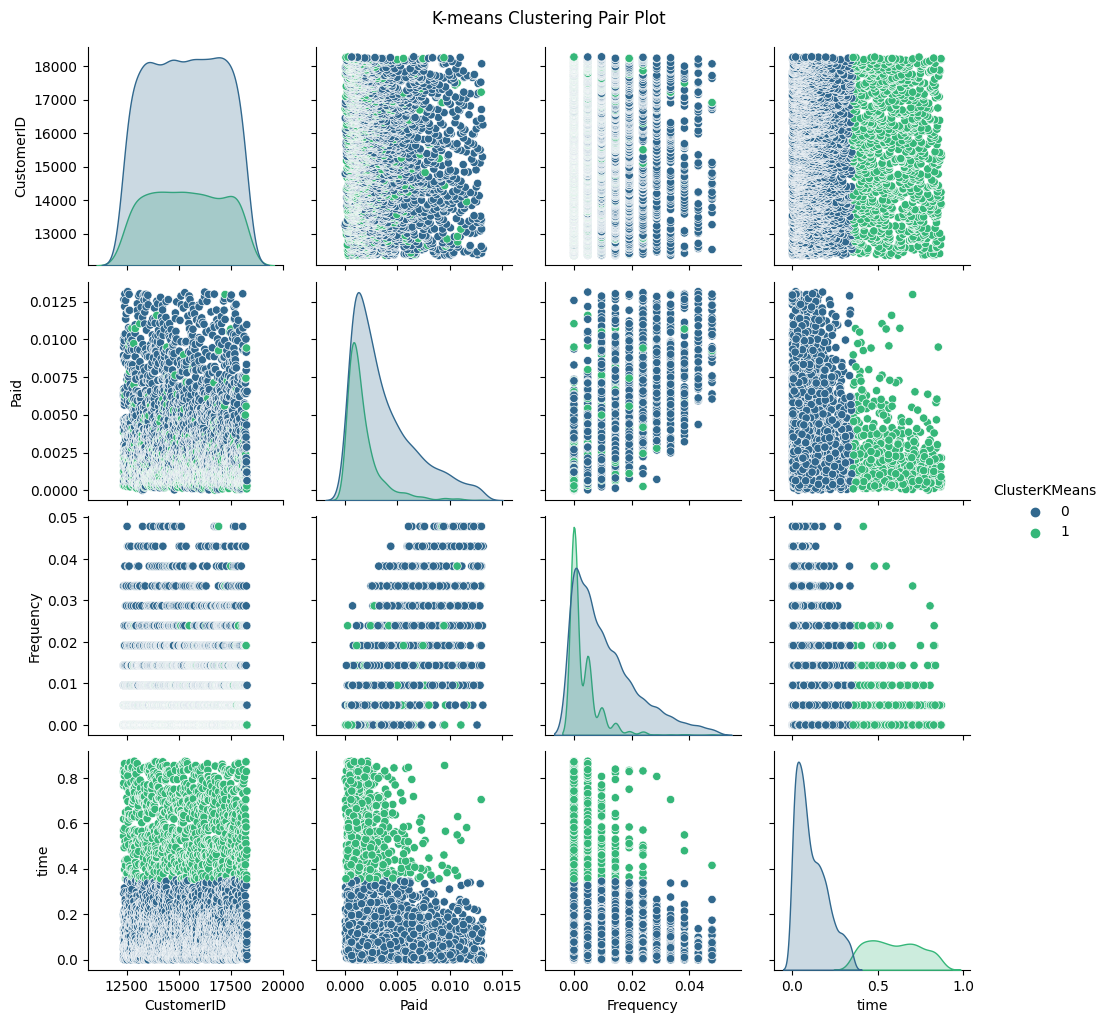

In [221]:

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Create pairplot with hue set to cluster assignments
    sns.pairplot(filtered_data, hue='ClusterKMeans', palette='viridis')
    plt.suptitle('K-means Clustering Pair Plot', y=1.02)
    plt.show()


In [222]:
# we will take 2 clusters.

In [223]:
filtered_data.head()

CustomerID      Paid  Frequency      time  ClusterKMeans
2     12348.0  0.006414   0.014354  0.198391              0
3     12349.0  0.006272   0.000000  0.048257              0
4     12350.0  0.001193   0.000000  0.828418              1
5     12352.0  0.008944   0.033493  0.093834              0
6     12353.0  0.000318   0.000000  0.544236              1

In [224]:
filtered_data2.head()

CustomerID      Paid  Frequency      time
2     12348.0  0.006414   0.014354  0.198391
3     12349.0  0.006272   0.000000  0.048257
4     12350.0  0.001193   0.000000  0.828418
5     12352.0  0.008944   0.033493  0.093834
6     12353.0  0.000318   0.000000  0.544236

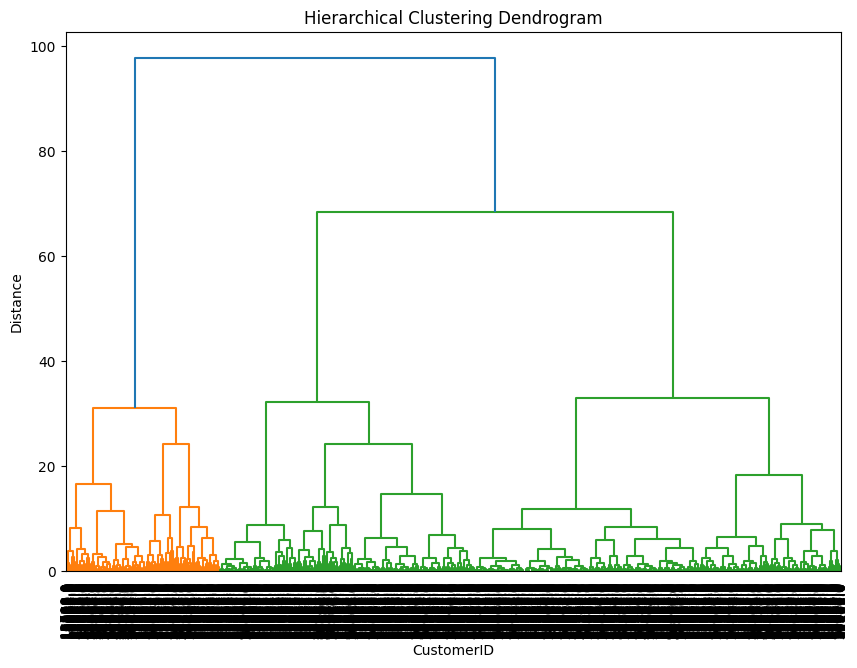

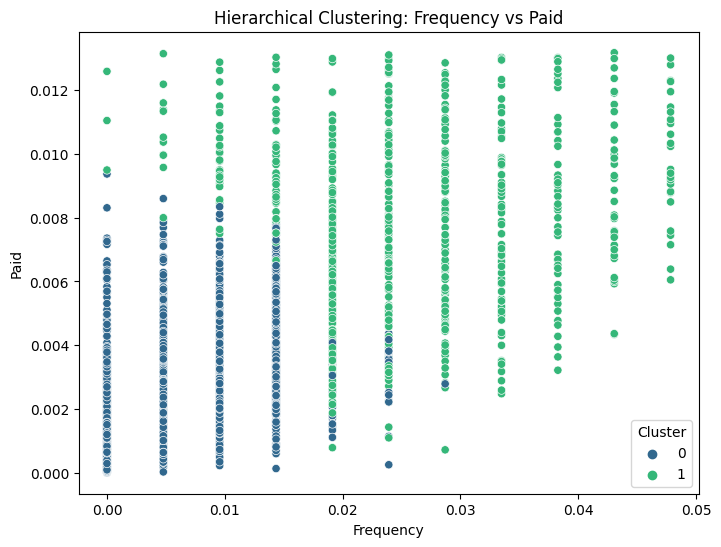

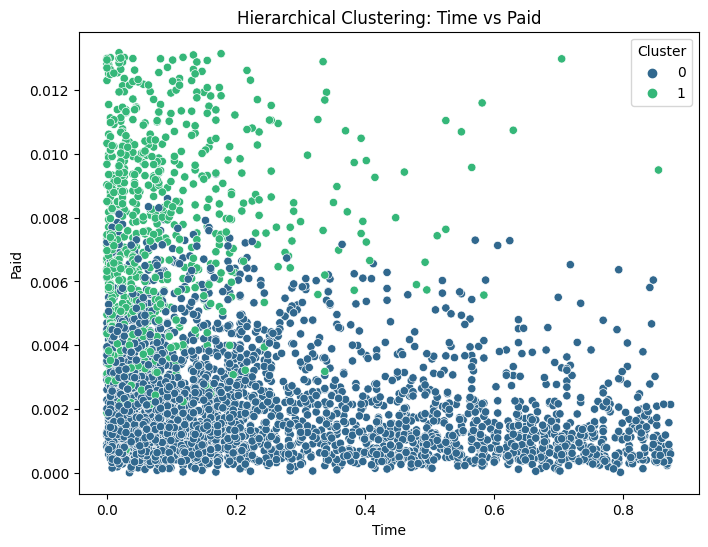

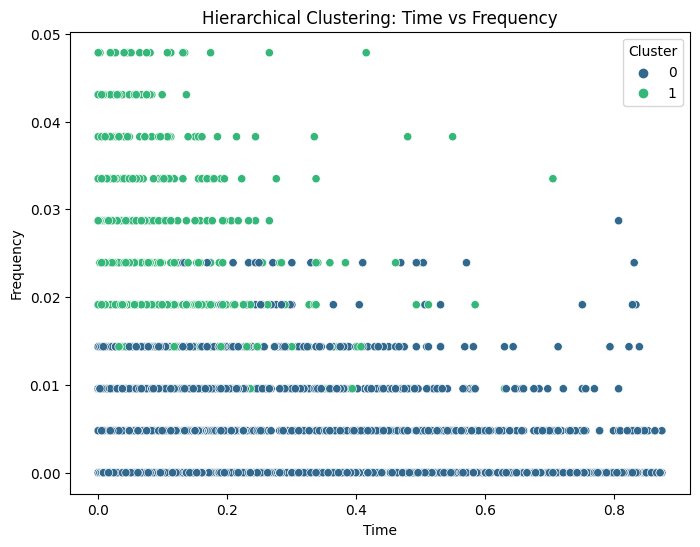

   CustomerID      Paid  Frequency      time  cluster_Hier
2     12348.0  0.006414   0.014354  0.198391             0
3     12349.0  0.006272   0.000000  0.048257             0
4     12350.0  0.001193   0.000000  0.828418             0
5     12352.0  0.008944   0.033493  0.093834             1
6     12353.0  0.000318   0.000000  0.544236             0


In [225]:
# Load the data (assuming filtered_data2 is already available)
# filtered_data2 = pd.read_csv('path_to_filtered_data2.csv')

# Define the columns for clustering (excluding 'CustomerID')
cluster_columns = ['Paid', 'Frequency', 'time']

# Standardize the data (optional but recommended for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered_data2[cluster_columns])

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=2)
cluster_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels to the DataFrame under a new column 'cluster_Hier'
filtered_data2['cluster_Hier'] = cluster_labels

# Visualize the dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=filtered_data2['CustomerID'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('CustomerID')
plt.ylabel('Distance')
plt.show()

# Create scatter plots to visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_data2, x='Frequency', y='Paid', hue='cluster_Hier', palette='viridis')
plt.title('Hierarchical Clustering: Frequency vs Paid')
plt.xlabel('Frequency')
plt.ylabel('Paid')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_data2, x='time', y='Paid', hue='cluster_Hier', palette='viridis')
plt.title('Hierarchical Clustering: Time vs Paid')
plt.xlabel('Time')
plt.ylabel('Paid')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_data2, x='time', y='Frequency', hue='cluster_Hier', palette='viridis')
plt.title('Hierarchical Clustering: Time vs Frequency')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.show()

# Display the updated DataFrame
print(filtered_data2.head())


In [226]:
filtered_data.head()

CustomerID      Paid  Frequency      time  ClusterKMeans
2     12348.0  0.006414   0.014354  0.198391              0
3     12349.0  0.006272   0.000000  0.048257              0
4     12350.0  0.001193   0.000000  0.828418              1
5     12352.0  0.008944   0.033493  0.093834              0
6     12353.0  0.000318   0.000000  0.544236              1

In [227]:
filtered_data2.head()

CustomerID      Paid  Frequency      time  cluster_Hier
2     12348.0  0.006414   0.014354  0.198391             0
3     12349.0  0.006272   0.000000  0.048257             0
4     12350.0  0.001193   0.000000  0.828418             0
5     12352.0  0.008944   0.033493  0.093834             1
6     12353.0  0.000318   0.000000  0.544236             0

In [228]:
rfm_details5 = rfm_details2.copy()
rfm_details5= pd.merge(rfm_details2, min_diff_per_customer, on='CustomerID', how='left')

In [229]:
rfm_details5.head()

CustomerID      Paid  Frequency  time
0     12346.0  77183.60          1   325
1     12347.0   4310.00          7     1
2     12348.0   1797.24          4    74
3     12349.0   1757.55          1    18
4     12350.0    334.40          1   309

In [230]:
merged1 = pd.merge(filtered_data[['CustomerID', 'ClusterKMeans']], filtered_data2[['CustomerID', 'cluster_Hier']], on='CustomerID', how='inner')
merged2 = pd.merge(merged1, rfm_details5, on='CustomerID', how='inner')

# Select the desired columns
rfm_clustered = merged2[['CustomerID', 'Paid', 'Frequency', 'time', 'ClusterKMeans', 'cluster_Hier']]

# Order by CustomerID
rfm_clustered = rfm_clustered.sort_values(by='CustomerID')

# Reset index (optional)
rfm_clustered = rfm_clustered.reset_index(drop=True)

rfm_clustered.head()

CustomerID     Paid  Frequency  time  ClusterKMeans  cluster_Hier
0     12348.0  1797.24          4    74              0             0
1     12349.0  1757.55          1    18              0             0
2     12350.0   334.40          1   309              1             0
3     12352.0  2506.04          8    35              0             1
4     12353.0    89.00          1   203              1             0

In [231]:
rfm_clustered.describe()

CustomerID         Paid    Frequency         time  ClusterKMeans  \
count   3711.000000  3711.000000  3711.000000  3711.000000    3711.000000   
mean   15325.693883   887.112286     2.835893    89.127728       0.262732   
std     1702.646022   813.532054     2.193169    88.905688       0.440178   
min    12348.000000     0.000000     1.000000     0.000000       0.000000   
25%    13858.500000   296.335000     1.000000    21.000000       0.000000   
50%    15327.000000   602.510000     2.000000    55.000000       0.000000   
75%    16798.000000  1244.710000     4.000000   138.000000       1.000000   
max    18287.000000  3692.280000    11.000000   326.000000       1.000000   

       cluster_Hier  
count   3711.000000  
mean       0.198599  
std        0.398999  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

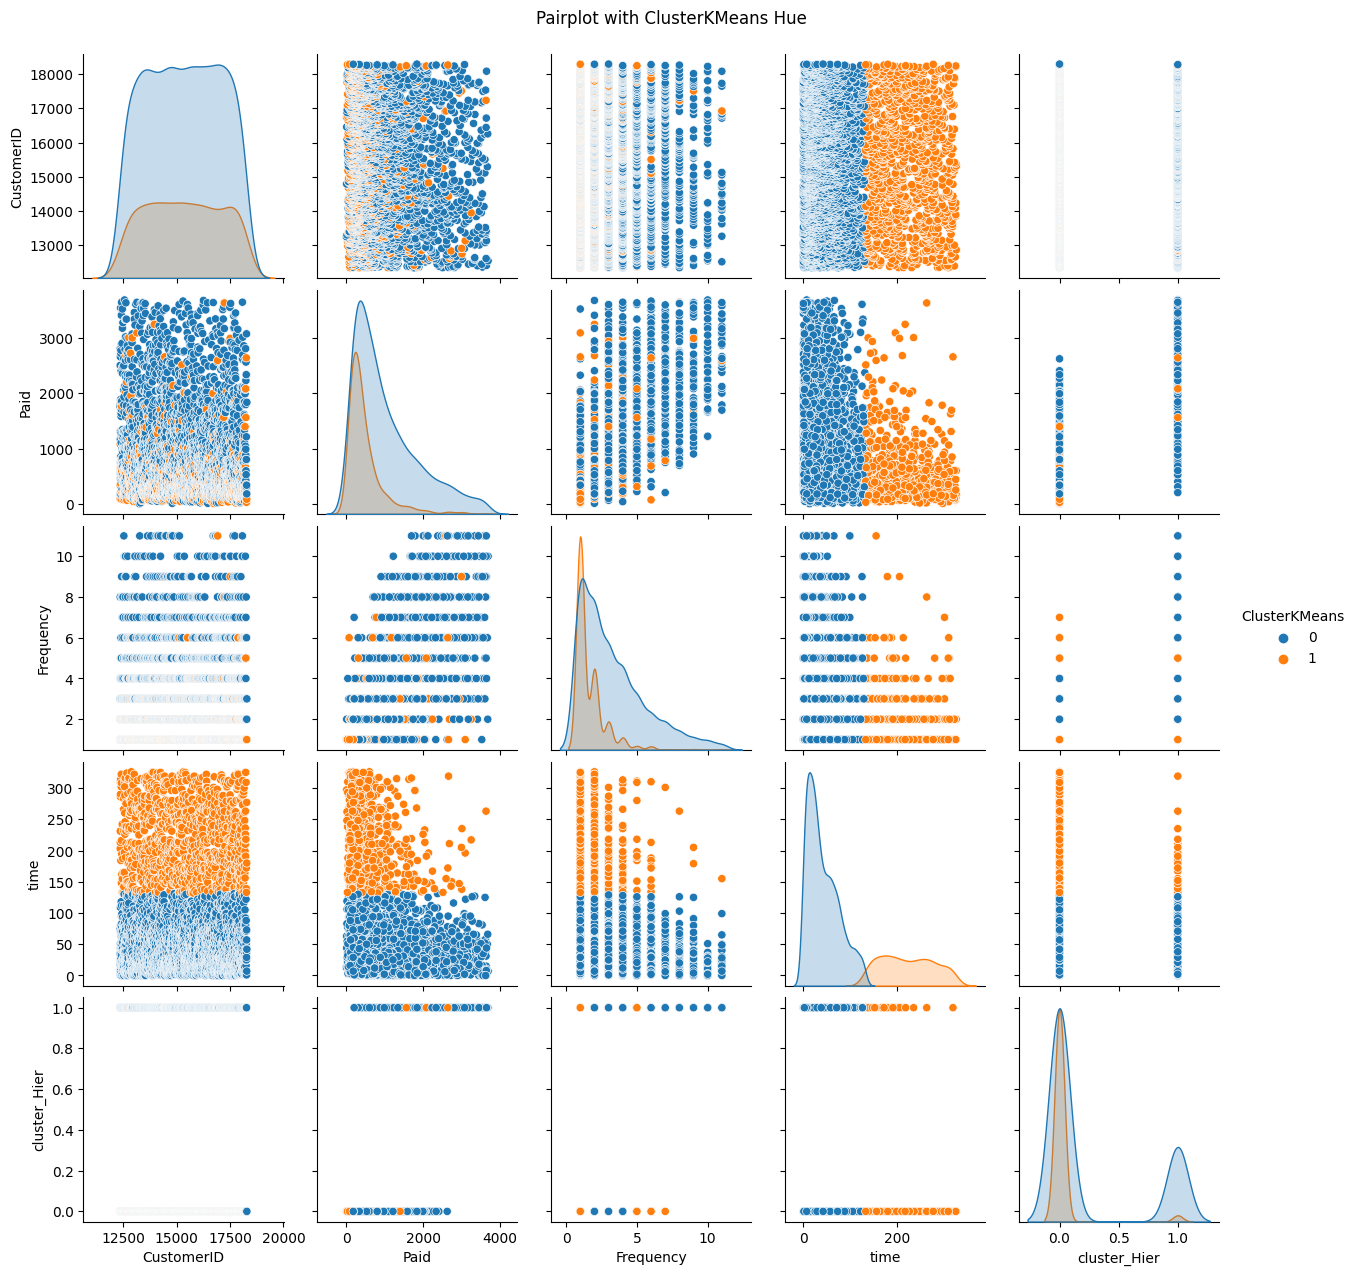

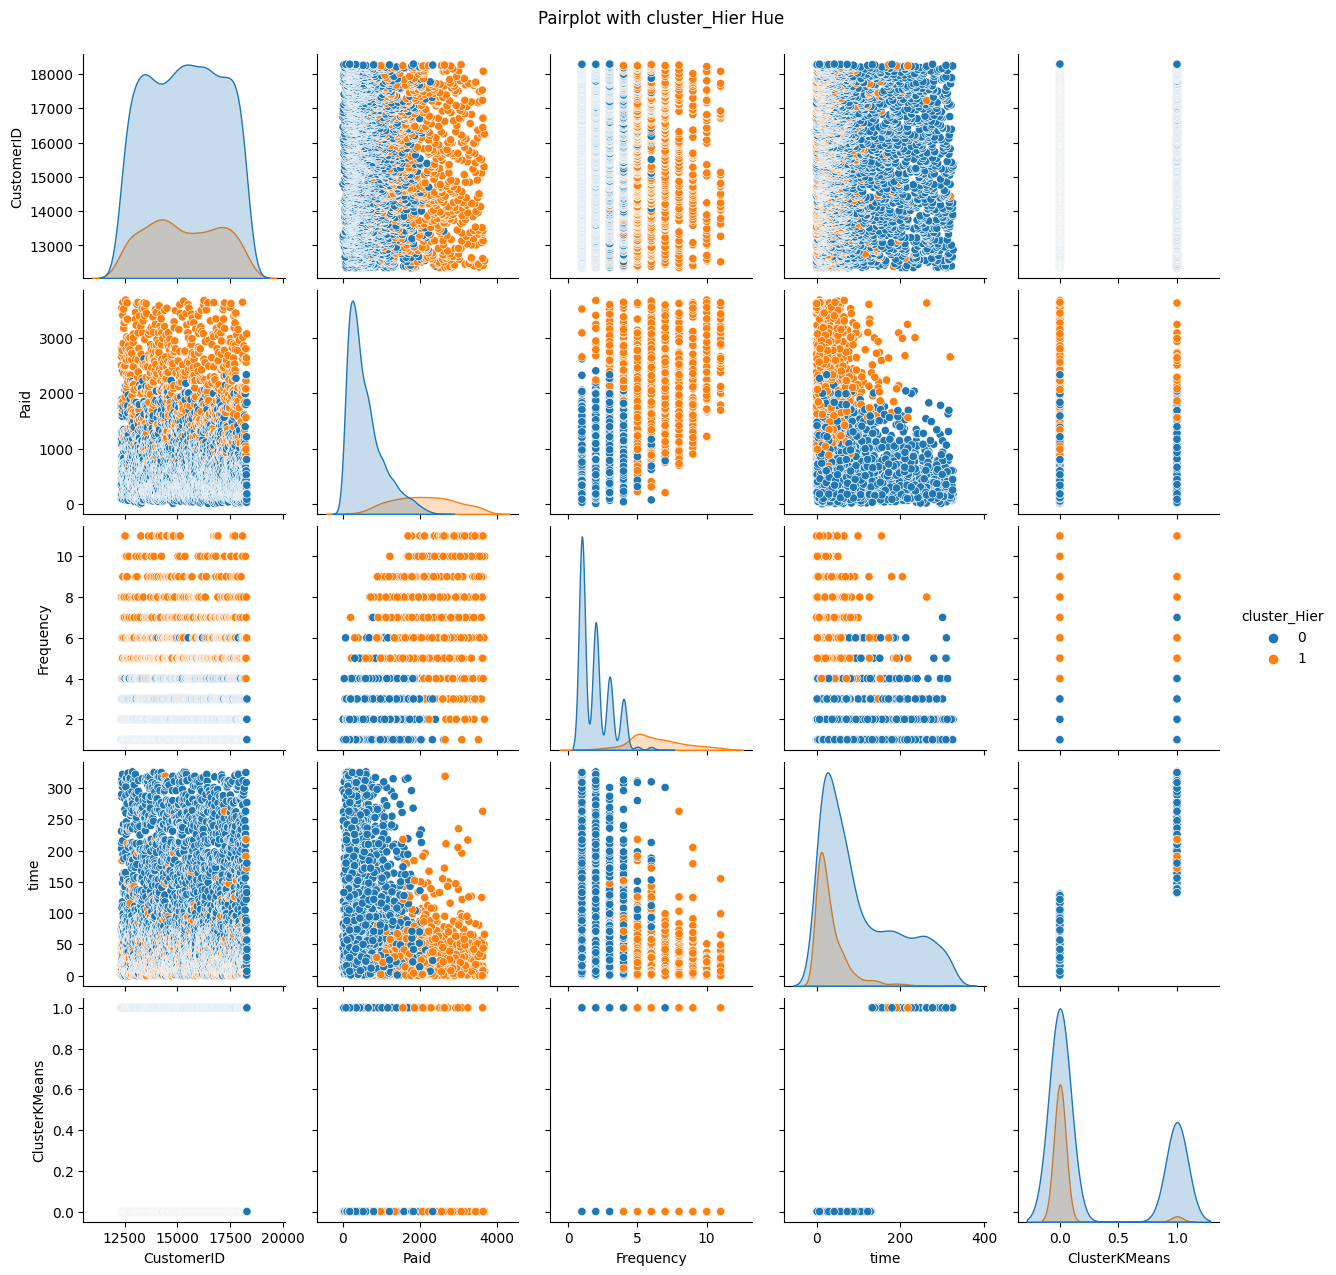

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Create pairplot with hue set to ClusterKMeans
    sns.pairplot(rfm_clustered, hue='ClusterKMeans')
    plt.suptitle('Pairplot with ClusterKMeans Hue', y=1.02)
    plt.show()

    # Create pairplot with hue set to cluster_Hier
    sns.pairplot(rfm_clustered, hue='cluster_Hier')
    plt.suptitle('Pairplot with cluster_Hier Hue', y=1.02)
    plt.show()


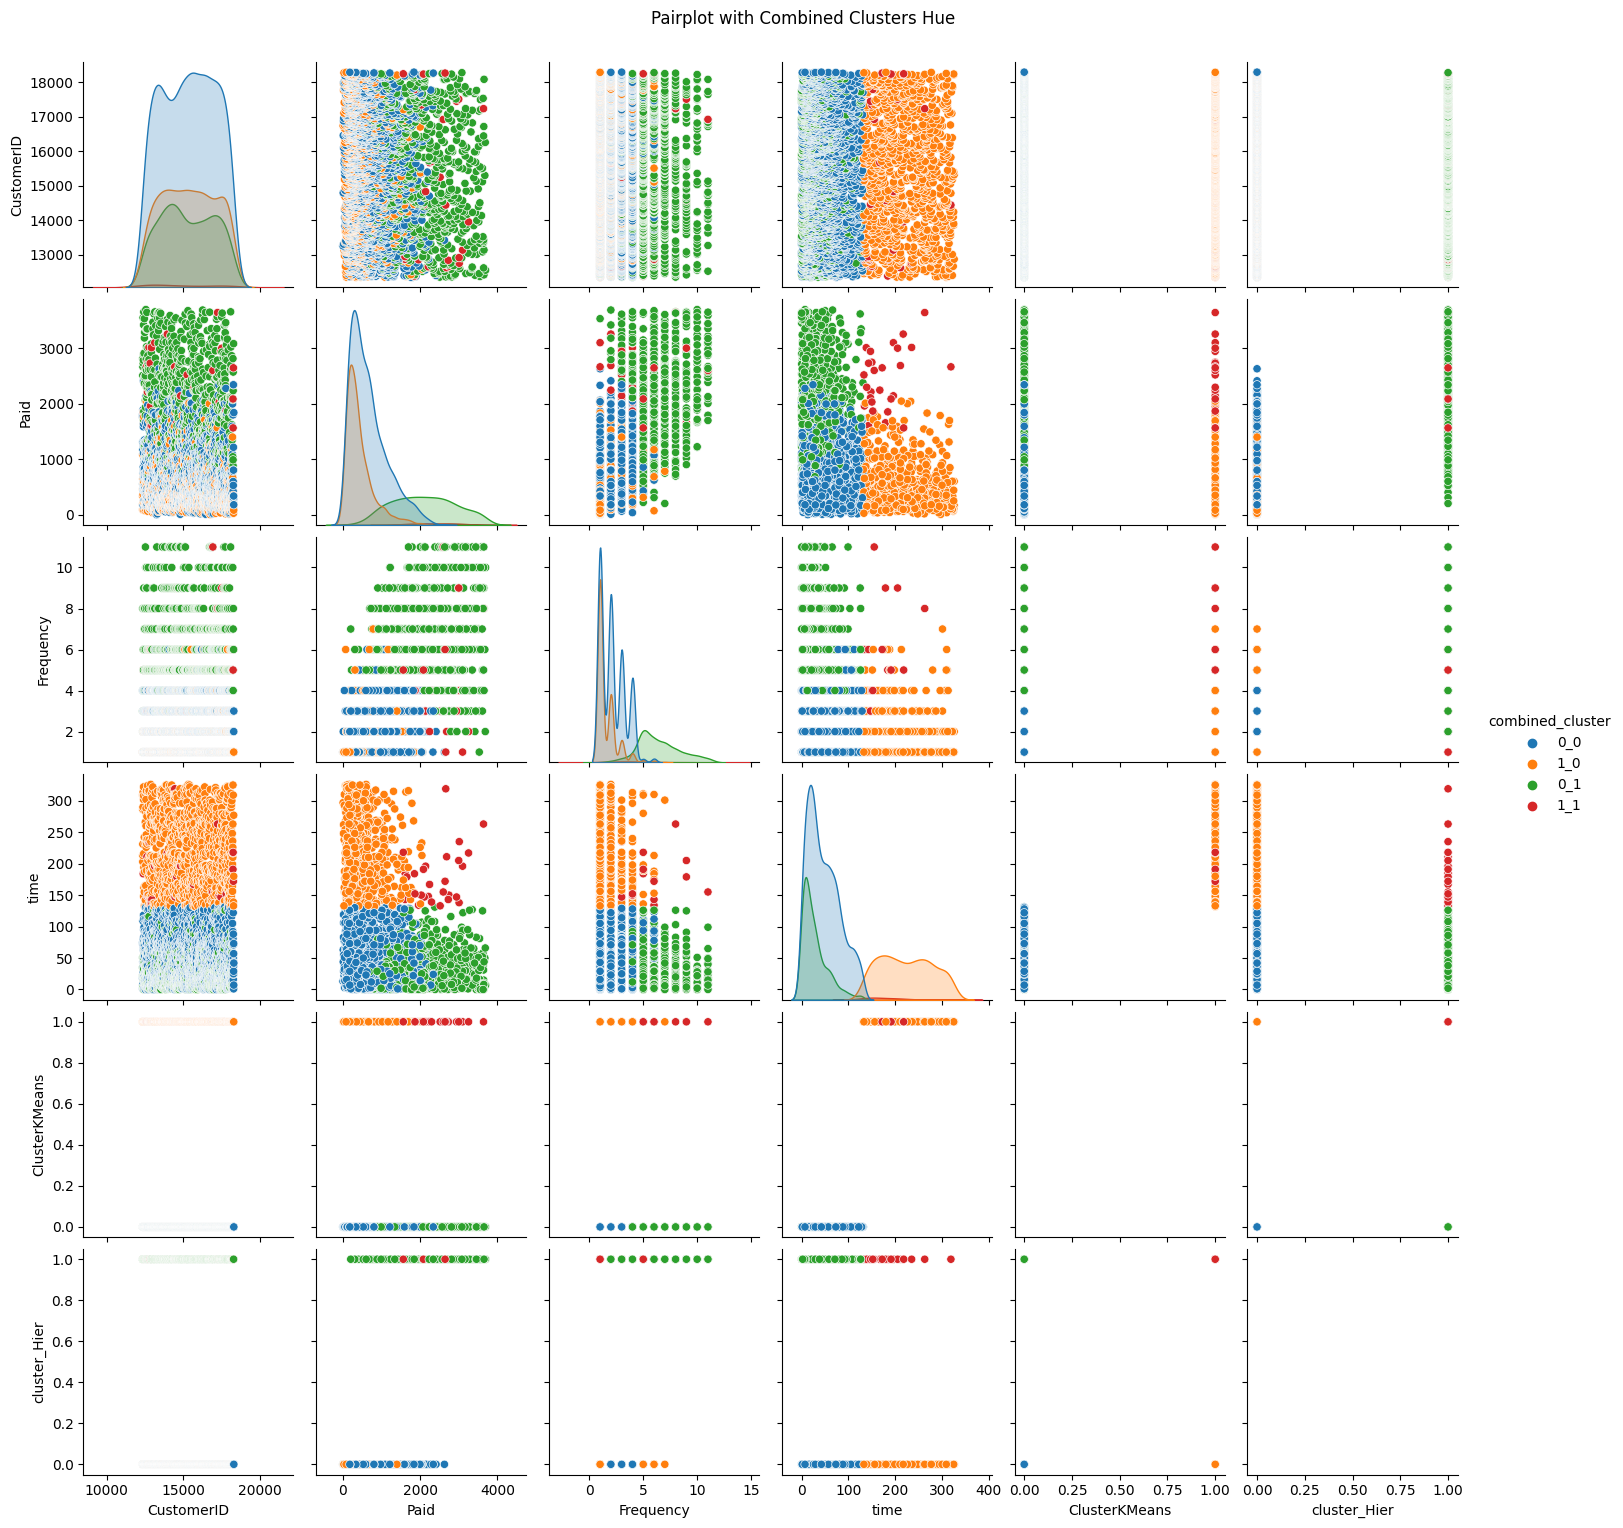

In [233]:

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Combine both cluster labels into a single string column for a single hue
    rfm_clustered['combined_cluster'] = rfm_clustered['ClusterKMeans'].astype(str) + "_" + rfm_clustered['cluster_Hier'].astype(str)

    # Create a pairplot with the combined clusters as hue
    sns.pairplot(rfm_clustered, hue='combined_cluster')
    plt.suptitle('Pairplot with Combined Clusters Hue', y=1.02)
    plt.show()


In [234]:
rfm_clustered.head()

CustomerID     Paid  Frequency  time  ClusterKMeans  cluster_Hier  \
0     12348.0  1797.24          4    74              0             0   
1     12349.0  1757.55          1    18              0             0   
2     12350.0   334.40          1   309              1             0   
3     12352.0  2506.04          8    35              0             1   
4     12353.0    89.00          1   203              1             0   

  combined_cluster  
0              0_0  
1              0_0  
2              1_0  
3              0_1  
4              1_0

In [235]:
rfm_clustered.describe()

CustomerID         Paid    Frequency         time  ClusterKMeans  \
count   3711.000000  3711.000000  3711.000000  3711.000000    3711.000000   
mean   15325.693883   887.112286     2.835893    89.127728       0.262732   
std     1702.646022   813.532054     2.193169    88.905688       0.440178   
min    12348.000000     0.000000     1.000000     0.000000       0.000000   
25%    13858.500000   296.335000     1.000000    21.000000       0.000000   
50%    15327.000000   602.510000     2.000000    55.000000       0.000000   
75%    16798.000000  1244.710000     4.000000   138.000000       1.000000   
max    18287.000000  3692.280000    11.000000   326.000000       1.000000   

       cluster_Hier  
count   3711.000000  
mean       0.198599  
std        0.398999  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [236]:
cluster_kmeans_0 = rfm_clustered[rfm_clustered['ClusterKMeans'] == 0]

# Filter rows where ClusterKMeans is 1
cluster_kmeans_1 = rfm_clustered[rfm_clustered['ClusterKMeans'] == 1]

In [237]:
cluster_kmeans_0.describe()

CustomerID         Paid    Frequency         time  ClusterKMeans  \
count   2736.000000  2736.000000  2736.000000  2736.000000         2736.0   
mean   15319.057749  1030.637344     3.260965    41.826754            0.0   
std     1697.240874   855.608251     2.323371    33.313732            0.0   
min    12348.000000     0.000000     1.000000     0.000000            0.0   
25%    13859.500000   363.857500     1.000000    15.000000            0.0   
50%    15337.000000   745.940000     3.000000    32.000000            0.0   
75%    16790.250000  1469.837500     4.000000    64.000000            0.0   
max    18287.000000  3692.280000    11.000000   131.000000            0.0   

       cluster_Hier  
count   2736.000000  
mean       0.259137  
std        0.438241  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [238]:
cluster_kmeans_1.describe()

CustomerID         Paid   Frequency        time  ClusterKMeans  \
count    975.000000   975.000000  975.000000  975.000000          975.0   
mean   15344.315897   484.358893    1.643077  221.861538            1.0   
std     1718.461953   495.038465    1.109873   55.406472            0.0   
min    12350.000000     3.750000    1.000000  132.000000            1.0   
25%    13857.500000   178.735000    1.000000  173.000000            1.0   
50%    15308.000000   325.750000    1.000000  217.000000            1.0   
75%    16816.500000   590.775000    2.000000  266.000000            1.0   
max    18281.000000  3638.410000   11.000000  326.000000            1.0   

       cluster_Hier  
count    975.000000  
mean       0.028718  
std        0.167098  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [239]:
cluster_Hier_0 = rfm_clustered[rfm_clustered['cluster_Hier'] == 0]

# Filter rows where ClusterKMeans is 1
cluster_Hier_1 = rfm_clustered[rfm_clustered['cluster_Hier'] == 1]

In [240]:
cluster_Hier_0.describe()

CustomerID         Paid    Frequency         time  ClusterKMeans  \
count   2974.000000  2974.000000  2974.000000  2974.000000    2974.000000   
mean   15340.432078   584.478787     1.967720   102.886348       0.318426   
std     1700.038401   455.068835     1.100546    92.250517       0.465944   
min    12348.000000     0.000000     1.000000     0.000000       0.000000   
25%    13858.250000   238.987500     1.000000    27.000000       0.000000   
50%    15373.000000   445.460000     2.000000    69.000000       0.000000   
75%    16792.750000   797.290000     3.000000   170.000000       1.000000   
max    18287.000000  2626.300000     7.000000   326.000000       1.000000   

       cluster_Hier  
count        2974.0  
mean            0.0  
std             0.0  
min             0.0  
25%             0.0  
50%             0.0  
75%             0.0  
max             0.0

In [241]:
cluster_Hier_1.describe()

CustomerID         Paid   Frequency        time  ClusterKMeans  \
count    737.000000   737.000000  737.000000  737.000000     737.000000   
mean   15266.221167  2108.322634    6.339213   33.607870       0.037992   
std     1712.998563   797.606647    2.004478   40.196793       0.191306   
min    12352.000000   201.120000    1.000000    0.000000       0.000000   
25%    13860.000000  1474.720000    5.000000    8.000000       0.000000   
50%    15134.000000  2095.130000    6.000000   21.000000       0.000000   
75%    16813.000000  2709.700000    8.000000   44.000000       0.000000   
max    18272.000000  3692.280000   11.000000  319.000000       1.000000   

       cluster_Hier  
count         737.0  
mean            1.0  
std             0.0  
min             1.0  
25%             1.0  
50%             1.0  
75%             1.0  
max             1.0

**K-Means Clustering**

- Cluster 0:
  This cluster consists of 2736 customers with an average payment of 1030, frequency 3.2, and time of last purchase 41.8 days.
- Cluster 1:
  This cluster consists of 975 customers, with an average payment of 484, frquency of 1.6 and time of last purchase 221 days.
  
*Cluster zero customers are of a higher value to the company as they are more recent, high spender and frequent purchasers.*

**Hierarchical Clustering**

- Cluster 0:
  This cluster consists of 2974 customers with an average payment of 584, frequency 2, and time of last purchase 102 days.
- Cluster 1:
  This cluster consists of 737 customers, with an average payment of 2108, frquency of 6.3 and time of last purchase 33.6 days.
  
*Cluster one customers are of a higher value to the company as they are more recent, high spender and frequent purchasers.*

**Overall Summary**

Kmeans clustering gives us a more general, bird eye view on valuable customers, whereas Hierarchical Clustering is more sharp and pointed outlook on customer of high importance.

# This document ends here, Thanks for reading!